# Within-chromosome co-occurrence analysis

In the [pairwise analysis](Pairwise analysis.ipynb), we found no evidence for widespread co-occurrence. To establish that the DISCOVER test is not overly conservative with respect to co-occurrence, we test for co-occurrence of copy number alterations of genes located in the same copy number segment, chromosome arm, or chromosome. Because of the strong correlation between copy numbers of nearby genes, we consider such gene pairs positive controls.

In [1]:
import sys
sys.path.append("../lib")

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy
import scipy.stats

In [5]:
import nbsupport.io
import nbsupport.plots
import nbsupport.tcga

In [6]:
import discover

## Data and results

We use the results of the pairwise mutual exclusivity analysis obtained in the notebook [Pairwise analysis](Pairwise analysis.ipynb).

In [7]:
dataFile = "../data/tcga/tcga-pancan12.h5"

In [8]:
events = nbsupport.io.load_discover_matrix(dataFile, "/models/combined")

In [9]:
result_cooc = discover.pairwise_discover_test(events, alternative="greater")

## Within-chromosome analyses

In the plot below, we compare the co-occurrence $P$-values for pairs of genes located within the same recurrently altered segment, within the same chromosome arm, within the same chromosome, and across chromosomes.

In [10]:
segments = {}

for event_type in ["amp", "del"]:
    peaks = nbsupport.tcga.read_gistic_output("../data/tcga/%s_genes.conf_95.pancan12.txt" % event_type)
    segments.update({ gene.strip("[]") + "_" + {"amp": "gain", "del": "loss"}[event_type]: seg for seg in peaks for gene in peaks[seg] })

In [11]:
seg = numpy.array([segments.get(gene, "NA") for gene in events.rownames])

In [12]:
chrom_arm = numpy.array([x if x == "NA" else x[:max(x.find("p"), x.find("q"))+1] for x in seg])

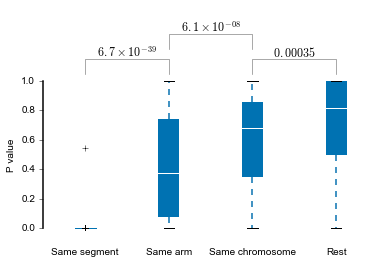

In [13]:
from numpy import newaxis

same_segment = seg[:, newaxis] == numpy.char.replace(seg[newaxis], "NA", "NA2")
same_arm = ~same_segment & (chrom_arm[:, newaxis] == numpy.char.replace(chrom_arm[newaxis], "NA", "NA2"))

chrom = numpy.char.replace(numpy.char.replace(chrom_arm, "p", ""), "q", "")
same_chrom = ~same_segment & ~same_arm & (chrom[:, newaxis] == numpy.char.replace(chrom[newaxis], "NA", "NA2"))

rest = ~same_segment & ~same_arm & ~same_chrom & (seg != "NA")[:, newaxis] & (seg != "NA")[newaxis]

data = [numpy.ma.masked_invalid(result_cooc.pvalues.values[same_segment]).compressed(),
        numpy.ma.masked_invalid(result_cooc.pvalues.values[same_arm]).compressed(),
        numpy.ma.masked_invalid(result_cooc.pvalues.values[same_chrom]).compressed(),
        numpy.ma.masked_invalid(result_cooc.pvalues.values[rest]).compressed()]

with plt.rc_context(rc={"font.size": 12,
                        "legend.fontsize": 12,
                        "axes.linewidth": 1.5,
                        
                        'mathtext.fontset': 'custom',
                        'mathtext.rm': 'Arial',
                        'mathtext.it': 'Arial:italic',
                        'mathtext.bf': 'Arial:bold',
                        
                        "font.family": "arial"}):
    bp = plt.boxplot(data, widths=0.25)
    
    ax = plt.gca()
    
    plt.setp(bp["boxes"], color="#31a354", lw=0)
    plt.setp(bp["medians"], color="white")
    plt.setp(bp["medians"][0], color="#0072b2")
    plt.setp(bp["whiskers"], color="#4393c3", lw=2)
    plt.setp(bp["caps"], color="black")
    plt.setp(bp["fliers"], color="red")
    
    for box in bp["boxes"]:
        coords = zip(box.get_xdata(), box.get_ydata())
        ax.add_patch(plt.Polygon(coords, fc="#0072b2", lw=0))
    
    for i in xrange(len(data) - 1):
        y = 1.03 if i % 2 == 0 else 1.2
        ax.annotate("", xy=(i + 1, y), xycoords="data", xytext=(i + 2, y), textcoords="data",
                    arrowprops={"arrowstyle": "-",
                                "ec": "#aaaaaa",
                                "connectionstyle": "bar,fraction=0.2"})
        p = scipy.stats.mannwhitneyu(data[i], data[i + 1]).pvalue
        ptext = ("$%.2g}$" % p).replace("e", "\\times 10^{")
        ax.text(i + 1.5, y + 0.17, ptext, ha="center", va="center")

    plt.ylim(-0.01, 1.5)
    plt.xticks([1, 2, 3, 4], ["Same segment", "Same arm", "Same chromosome", "Rest"])
    
    ax.axes.spines["left"].set_bounds(0, 1)
    ax.yaxis.set_ticks(numpy.linspace(0, 1, 6))
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.spines['bottom'].set_visible(False)
    ax.axes.yaxis.set_ticks_position('left')
    ax.axes.xaxis.set_ticks_position('none')
    ax.axes.tick_params(direction="out", which="both")
    ax.spines['bottom'].set_position(('outward', 10))
    
    yPos = ax.transAxes.inverted().transform(ax.transData.transform_point((0, 0.5)))[1]
    plt.ylabel("P value", y=yPos)


We also count the number of pairs identified as co-occurrent at a maximum FDR of 1%.

In [14]:
print "Pairs in same segment:"
print "  tested:     ", numpy.isfinite(result_cooc.pvalues.values[same_segment]).sum()
print "  significant:", (result_cooc.qvalues.values[same_segment] * result_cooc.pi0 < 0.01).sum()

Pairs in same segment:
  tested:      112
  significant: 111


In [15]:
print "Pairs on same chromosome arm:"
print "  tested:     ", numpy.isfinite(result_cooc.pvalues.values[same_arm]).sum()
print "  significant:", (result_cooc.qvalues.values[same_arm] * result_cooc.pi0 < 0.01).sum()

Pairs on same chromosome arm:
  tested:      159
  significant: 18


In [16]:
print "Pairs on same chromosome:"
print "  tested:     ", numpy.isfinite(result_cooc.pvalues.values[same_chrom]).sum()
print "  significant:", (result_cooc.qvalues.values[same_chrom] * result_cooc.pi0 < 0.01).sum()

Pairs on same chromosome:
  tested:      159
  significant: 1
